<a href="https://colab.research.google.com/github/Pranaydeepk/Rainfall-Prediction/blob/main/Rainfall_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Data Exploration

In [32]:
full_data.shape

(10533, 24)

In [33]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10533 entries, 0 to 10532
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           10533 non-null  object 
 1   Location       10533 non-null  object 
 2   MinTemp        10510 non-null  float64
 3   MaxTemp        10526 non-null  float64
 4   Rainfall       10450 non-null  float64
 5   Evaporation    4213 non-null   float64
 6   Sunshine       1948 non-null   float64
 7   WindGustDir    10432 non-null  object 
 8   WindGustSpeed  10432 non-null  float64
 9   WindDir9am     9560 non-null   object 
 10  WindDir3pm     10410 non-null  object 
 11  WindSpeed9am   10489 non-null  float64
 12  WindSpeed3pm   10488 non-null  float64
 13  Humidity9am    10382 non-null  float64
 14  Humidity3pm    10374 non-null  float64
 15  Pressure9am    10356 non-null  float64
 16  Pressure3pm    10349 non-null  float64
 17  Cloud9am       5497 non-null   float64
 18  Cloud3

In [34]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

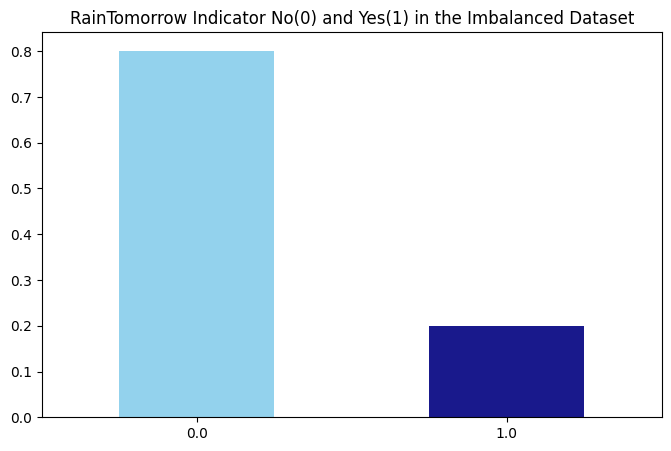

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

# Handling Class Imbalance For Rainfall Prediction

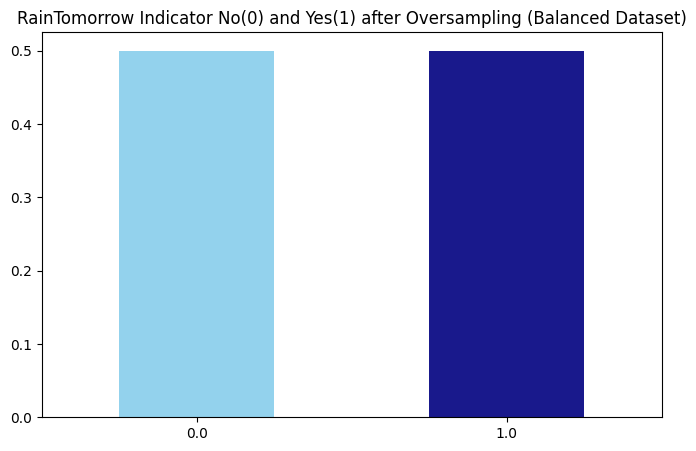

In [36]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

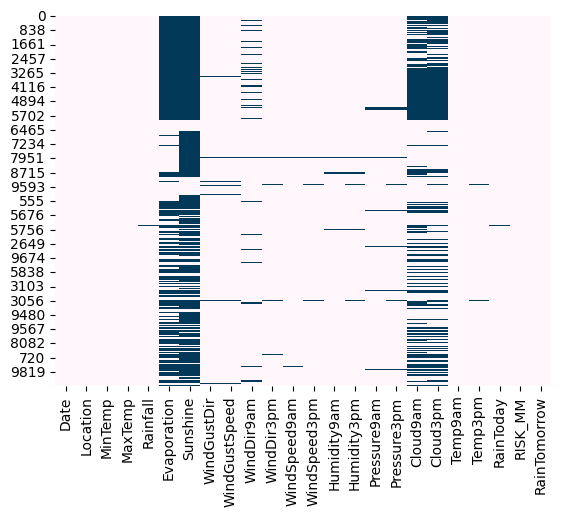

In [37]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [38]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,13315,0.788897
Evaporation,10174,0.602797
Cloud9am,7370,0.436663
Cloud3pm,7057,0.418118


# Imputation and Transformation

In [39]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [40]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [41]:
# Code language: PHP (php)

# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [42]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [43]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1443.000000
Location            2.000000
MinTemp             9.900000
MaxTemp             9.800000
Rainfall            2.136823
Evaporation         4.516519
Sunshine            6.353228
WindGustDir         8.000000
WindGustSpeed      16.000000
WindDir9am          8.000000
WindDir3pm          7.000000
WindSpeed9am       11.000000
WindSpeed3pm       11.000000
Humidity9am        29.000000
Humidity3pm        34.133358
Pressure9am         9.300000
Pressure3pm         9.300000
Cloud9am            4.000000
Cloud3pm            3.966269
Temp9am             8.800000
Temp3pm             9.500000
RainToday           1.000000
RISK_MM             5.800000
RainTomorrow        1.000000
dtype: float64


In [44]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(12063, 24)

<Axes: >

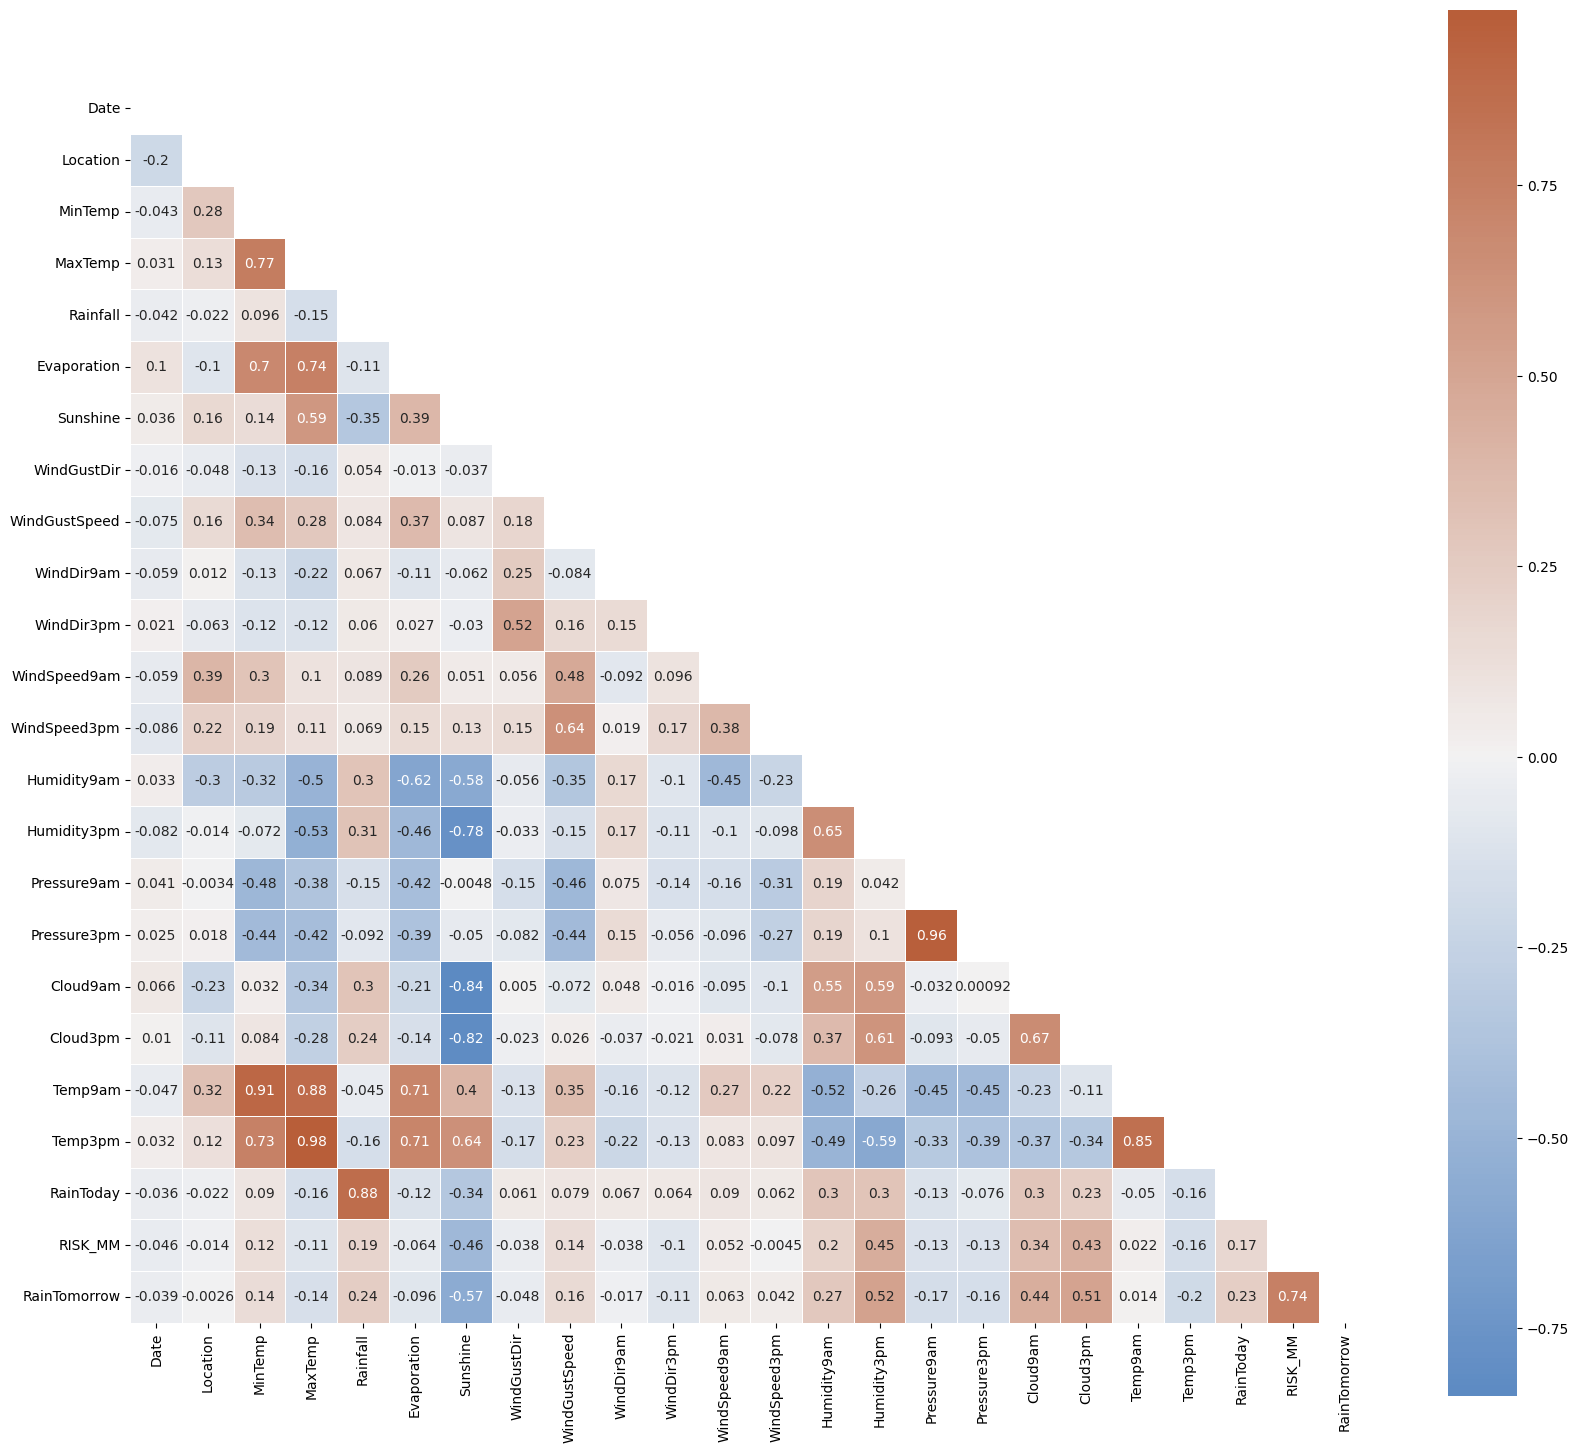

In [45]:
# strongly correlated with another.

# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

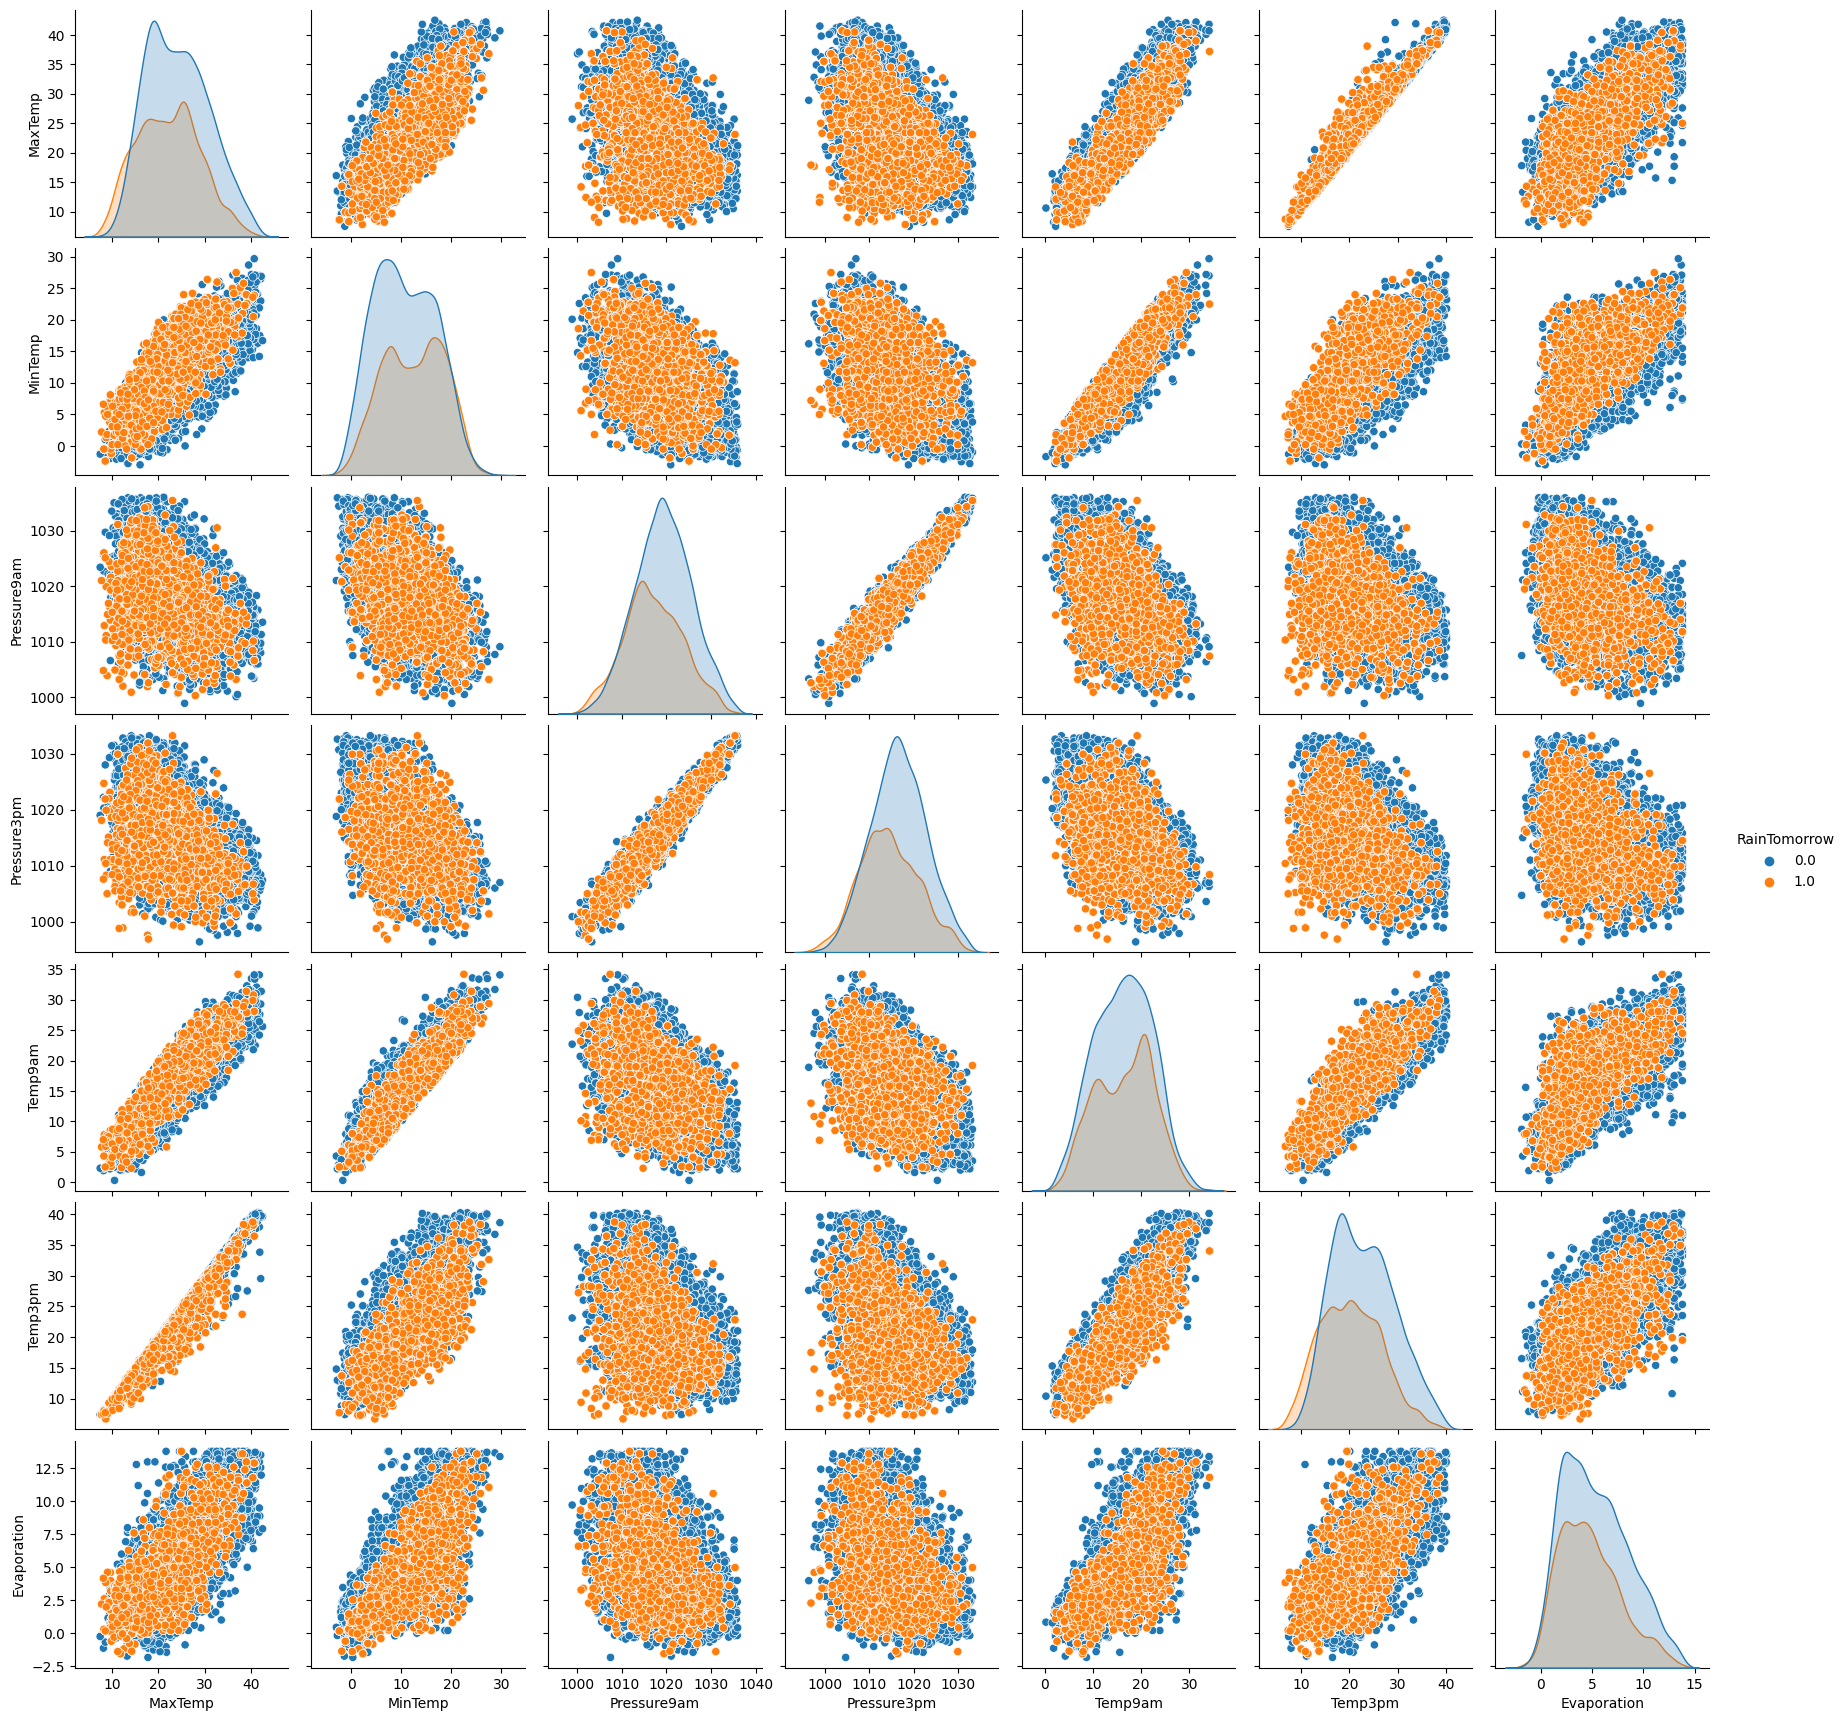

In [46]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

# Feature Selection for Rainfall Prediction

In [47]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [48]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindDir3pm', 'Humidity9am', 'Humidity3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Cloud3pm', 'RISK_MM']
[0.00440467 0.00331766 0.00664718 0.0064239  0.0101121  0.00411888
 0.07609101 0.0046897  0.01098624 0.00355509 0.00574142 0.00318442
 0.00485149 0.01122038 0.04586341 0.00802332 0.01038151 0.03256811
 0.0675108  0.00782053 0.00701202 0.00320304 0.66227311]


In [50]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [51]:
# Code language: PHP (php)

def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [60]:
!pip install scikit-learn

In [61]:
!pip install scikit-learn matplotlib

In [64]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [1]:
from sklearn.metrics import plot_confusion_matrix

ImportError: ignored

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    cohen_kappa_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split

def run_model(model, X, y, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    t0 = time.time()
    if not verbose:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Class 0", "Class 1"])
    plt.yticks(tick_marks, ["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, accuracy, roc_auc, coh_kap, time_taken


In [5]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95,
         'max_depth': 16,
         'min_split_gain': 0.1,
         'n_estimators': 200,
         'num_leaves': 50,
         'reg_alpha': 1.2,
         'reg_lambda': 1.2,
         'subsample': 0.95,
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf,
                                filler_feature_values={2: value},
                                filler_feature_ranges={2: width},
                                legend=2)
    plt.title(lab)

plt.show()

# Rainfall Prediction Model Comparison

In [ ]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

In [ ]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()